In [4]:
from __future__ import annotations
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import gymnasium as gym

plt.rcParams["figure.figsize"] = (10, 5)

In [5]:
class Policy_Network(nn.Module):

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        super().__init__()
        hidden_space1 = 16
        hidden_space2 = 32

        self.shared_net = nn.Sequential(nn.Linear(obs_space_dims, hidden_space1), nn.Tanh(), nn.Linear(hidden_space1, hidden_space2), nn.Tanh())
        self.policy_mean_net = nn.Sequential(nn.Linear(hidden_space2, action_space_dims))
        self.policy_stddev_net = nn.Sequential(nn.Linear(hidden_space2, action_space_dims))

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:

        shared_features = self.shared_net(x.float())
        action_means = self.policy_mean_net(shared_features)
        action_stddevs = torch.log(1 + torch.exp(self.policy_stddev_net(shared_features)))

        return action_means, action_stddevs
    
class REINFORCE:

    def __init__(self, obs_space_dims: int, action_space_dims: int):

        self.learning_rate = 1e-4
        self.gamma = 0.99
        self.eps = 1e-6
        self.probs = []
        self.rewards = []
        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)
        action = action.numpy()
        self.probs.append(prob)

        return action
    
    def update(self):

        running_g = 0
        gs = []

        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)
        log_probs = torch.stack(self.probs)
        log_prob_mean = log_probs.mean()
        loss = -torch.sum(log_prob_mean * deltas)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.probs = []
        self.rewards = []

In [7]:
env = gym.make("InvertedPendulum-v5")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)
total_num_episodes = int(5e3)
obs_space_dims = env.observation_space.shape[0]
action_space_dims = env.action_space.shape[0]
rewards_over_seeds = []

for seed in [1, 2, 3, 5, 8]:
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    agent = REINFORCE(obs_space_dims, action_space_dims)
    rewards_over_episodes = []

    for episode in range(total_num_episodes):
        obs, info = wrapped_env.reset(seed=seed)
        done = False

        while not done:
            action = agent.sample_action(obs)
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent.rewards.append(reward)
            done = terminated or truncated

        rewards_over_episodes.append(wrapped_env.return_queue[-1])
        agent.update()

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(rewards_over_episodes)


Episode: 0 Average Reward: 7
Episode: 1000 Average Reward: 18
Episode: 2000 Average Reward: 38
Episode: 3000 Average Reward: 53
Episode: 4000 Average Reward: 70
Episode: 0 Average Reward: 77
Episode: 1000 Average Reward: 14
Episode: 2000 Average Reward: 19
Episode: 3000 Average Reward: 29
Episode: 4000 Average Reward: 44
Episode: 0 Average Reward: 56
Episode: 1000 Average Reward: 9
Episode: 2000 Average Reward: 15
Episode: 3000 Average Reward: 21
Episode: 4000 Average Reward: 42
Episode: 0 Average Reward: 83
Episode: 1000 Average Reward: 11
Episode: 2000 Average Reward: 16
Episode: 3000 Average Reward: 25
Episode: 4000 Average Reward: 35
Episode: 0 Average Reward: 51
Episode: 1000 Average Reward: 9
Episode: 2000 Average Reward: 17
Episode: 3000 Average Reward: 32
Episode: 4000 Average Reward: 53


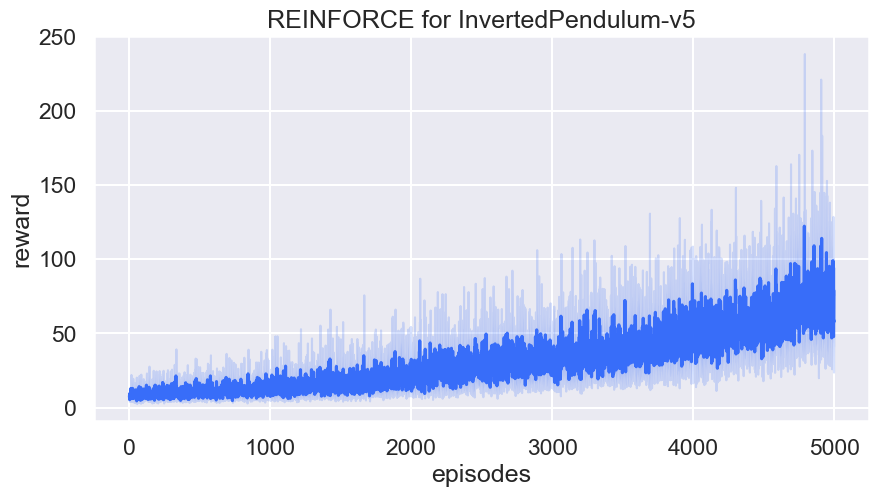

In [11]:
rewards_to_plot = [[reward for reward in rewards ] for rewards in rewards_over_seeds]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(title="REINFORCE for InvertedPendulum-v5")
plt.show()